# Магнитное поле прямого тока

Рассмотрим прямой проводник длиной $l$, по которому течёт постоянный ток величиной $I$. Будем искать (наблюдать) вектор магнитной индукции $\vec{B}$ во множестве точек $A$ на расстоянии $b$ от проводника.

![схема](pics/magnetic-line.png)

Представим проводник как набор $N$ элементов $d\vec{l}$. Вектор магнитной индукции в точке A$(x,y,z)$ от элемента проводника согласно закону Био — Савара — Лапласа определяется выражением:
  $$d\vec{B}(x,y,z) = \frac{\mu_0}{4\pi} \frac{I [\vec{r} \times d\vec{l}] }{r^3},$$ 
где $\vec{r}$ — радиус-вектор элемента проводника, направленный от точки наблюдения A; $\left[ \vec{r} \times d\vec{l} \right]$ — векторное произведение; $\mu_0 = 4\pi \cdot 10^{-7}$ Гн$\cdot$м — магнитная постоянная.

Пусть элемент проводника $d\vec{l}$ расположен между точками с координатами $(x_i,y_i,z_i)$ и $(x_{i-1}, y_{i-1}, z_{i-1})$ в декартовой системе координат, т.е.
$$d\vec{l} = \left\{x_i - x_{i-1}, y_i - y_{i-1}, z_i - z_{i-1} \right\}.$$
Его радиус-вектор из точки наблюдения A$(x,y,z)$ определяется координатами
$$\vec{r} = \left\{ \frac{x_i + x_{i-1}}{2} - x, \frac{y_i + y_{i-1}}{2} - y, \frac{z_i + z_{i-1}}{2} - z \right\}.$$

Суммарный вектор магнитной индукции от $N$ элементов проводника определяется выражением

$$\vec{B}(x,y,z) = \sum_{i=1}^N d\vec{B}(x,y,z) = \frac{\mu_0 I}{4\pi} \sum_{i=1}^N \frac{[ \vec{r} \times d\vec{l}]}{r^3}$$

## Подготовка вычислений

Начнём с импорта библиотек, которыми мы будем пользоваться в блокноте: `NumPy` для работы с массивами и `Matplotlib` для визуализации.

Предварительно выполним команду `%matplotlib inline`, специфичную для Jupyter (т.н. *magic command*), которая обеспечит встраивание графиков по месту, непосредственно в блокнот.

In [1]:
import numpy as np

# встраивать графики внутрь блокнота (вызывать ПЕРЕД импортом библиотеки)
%matplotlib inline
import matplotlib.pyplot as plt

### Проводник с током
Определим класс `WireElement`, описывающий элемент проводника. Полями класса будут координаты опорных точек `xyz_start` и `xyz_end` в виде массивов, а также величина тока `I`. Кроме того, у класса будет один метод `dB()`, который будет вычислять компоненты элементарного вектора магнитной индукции $d\vec{B}$.

In [2]:
# Магнитная постоянная
mu0 = 4*np.pi*1e-7

class WireElement:
    """
    Элемент проводника
    """
    def __init__(self, I, xyz_start, xyz_end):
        """
        Задание величины тока и местоположения элемента проводника
        
        Параметры
        ---------
        I: float
            величина электрического тока.
        xyz_start, xyz_end: numpy array float
            {x,y,z}-координаты начала и конца элемента.
        """
        self.I = I
        self.xyz_start = xyz_start
        self.xyz_end   = xyz_end
        
    def dB(self, XYZ):
        """
        Вычислить компоненты вектора магнитной индукции во всех узлах сетки
        от данного элемента проводника
        
        Параметры
        ---------
        XYZ: numpy array
            массив координат {x,y,z} узлов сетки.
        """
        
        # Вектор, задающий элемент проводника
        dl = self.xyz_end - self.xyz_start
        
        # Радиус-вектора до элемента проводника от каждого из узлов сетки
        r  = 0.5*(self.xyz_end + self.xyz_start) - XYZ
        
        # Длины радиус векторов
        rlen = np.linalg.norm(r, axis=3, keepdims=True)
        
        return  mu0/(4*np.pi) * self.I * np.cross(r, dl) / rlen**3

Пусть прямой проводник расположен вертикально: $x=0, -l/2 \leq y \leq l/2, z=0$. Зададим длину проводника $l$, величину текущего по нему тока $I = 1.0$, а число составляющих элементов $N$. Создадим проводник как массив из его элементарных частей.

In [3]:
wire_l = 10.0   # длина проводника
wire_I = 1.0    # ток проводника
wire_N = 100    # число элементарных частей

def make_wire():
    xyz_start = np.array( [0.0, -wire_l/2, 0.0] )  # координаты начала провода
    xyz_end   = np.array( [0.0, +wire_l/2, 0.0] )  # координаты конца провода
    xyz_step  = (xyz_end - xyz_start) / wire_N     # шаг элемента провода

    wire = []
    xyz = xyz_start
    for i in range(0, wire_N):
        xyz_im1, xyz_i = xyz, xyz + xyz_step  # точка i-1 и i на проводе
        wire.append( WireElement(wire_I, xyz_im1, xyz_i) )
        xyz = xyz_i
        
    return wire

wire_Elements = make_wire()

### Расчётная сетка
Определим трёхмерную декартовую сетку, состоящую из равномерно распределённых узлов. В качестве расчётной области выберем прямоугольный параллелепипед со сторонами $x,y,z \in \left[-2,2\right],\left[0,2\right],\left[-2,2\right]$.

Сетка `grid_XYZ` представляет из себя 4х-мерный массив с размерностями `(Ny, Nx, Nz, 3)`, где `N*` — число узлов вдоль каждого направления, 3 — число значений в каждом узле (координаты $x$, $y$ и $z$). Обратим внимание на особый порядок индексации массива (`y` следует перед `x`), который обусловлен особенностями функции `numpy.meshgrid()`.

Границы расчетной области обозначим переменными `{x,y,z}_start` и `{x,y,z}_end`, а число узлов вдоль каждого направления — `grid_N{x,y,z}`.

In [4]:
# Границы расчётной области
x_start, x_end = -2.0,  2.0            
y_start, y_end =  0.0,  2.0
z_start, z_end = -2.0,  2.0

# Число узлов сетки в каждом направлении
grid_Nx, grid_Ny, grid_Nz = 21, 2, 21

def make_grid():
    # Одномерные списки координат расчётной сетки
    x = np.linspace(x_start, x_end, grid_Nx)
    y = np.linspace(y_start, y_end, grid_Ny)
    z = np.linspace(z_start, z_end, grid_Nz)

    # 3D массивы с координатами каждого узла сетки,
    # размерности каждого: (grid_Ny, grid_Nx, grid_Nz)
    X, Y, Z = np.meshgrid(x, y, z)

    # Объединённый 4D массив координат: [ {x0,y0,z0}, {x1,y1,z1}, ... ]
    return np.stack( (X, Y, Z), axis=3 )

grid_XYZ = make_grid()
print('Размерность построенной расчётной сетки: (ny,nx,nz, nc) = ', grid_XYZ.shape)

Размерность построенной расчётной сетки: (ny,nx,nz, nc) =  (2, 21, 21, 3)


## Вычисления и результаты

Для начала инициализируем нулями массив для $x-$, $y-$ и $z-$ компонент индукции результирующего магнитного поля. Затем просуммируем в цикле индукции от каждого элементарного участка провода.

In [5]:
B = np.zeros_like(grid_XYZ)

for el in wire_Elements:
    B = B + el.dB(grid_XYZ)

Визуализируем поле как трёхмерное векторное, где длина вектора пропорциональна величина магнитной индукции.

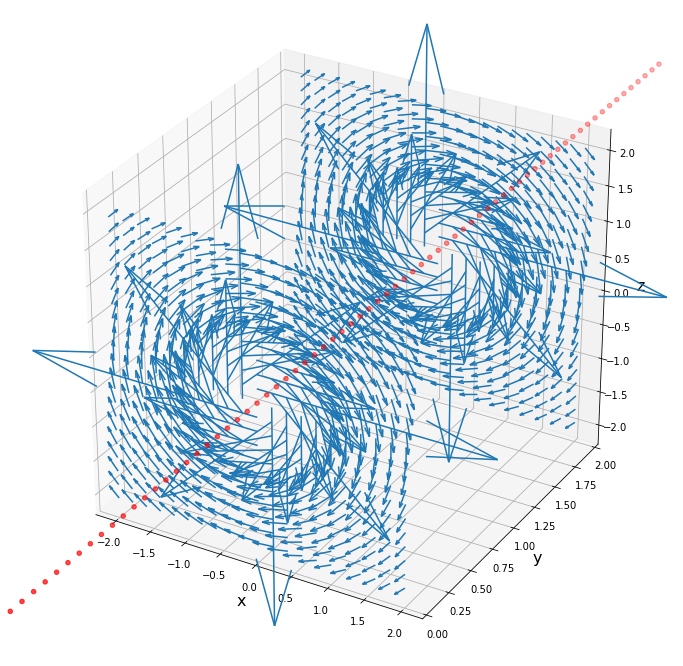

In [6]:
from mpl_toolkits.mplot3d import Axes3D

def make_vector_plot_3D():
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')

    ax.set_xlabel('x',fontsize=16)
    ax.set_ylabel('y',fontsize=16)
    ax.set_zlabel('z',fontsize=16)
    
    ax.set_ylim(y_start,y_end)

    # Векторное поле магнитной индукции
    X,Y,Z    = grid_XYZ[...,0], grid_XYZ[...,1], grid_XYZ[...,2]
    Bx,By,Bz = B[...,0], B[...,1], B[...,2]
    ax.quiver(X, Y, Z, Bx, By, Bz, length=4/mu0)

    # Точки, отмечающие элементарные участки провода
    xyz = np.array([ [ el.xyz_start[0], el.xyz_start[1], el.xyz_start[2] ] for el in wire_Elements ]).T
    ax.scatter(xyz[0],xyz[1],xyz[2], color='r', marker='o')
    
make_vector_plot_3D()

К сожалению, результат несколько зашумлён. В целом видно, что магнитное поле закручивается вокруг провода и падает с расстоянием (уменьшается длина стрелок), но также сильно выделяются по длине некоторые из них. Увеличенная длина соответствуют большой величине магнитной индукции вблизи провода, когда знаменатель в формуле для $B$ приближается к нулю. 

### Оценка точности

Для прямого проводника бесконечной длины точное теоретическое значение величины магнитной индукции в точке на расстоянии $b$ от проводника имеет вид:
$$|B(b)| = \frac{\mu_0}{2\pi} \frac{I}{b}$$

Для проводника, размещённого при $x=0, -\infty < y < +\infty, z=0$, на оси координат $x$ с учётом направления $\vec{B}$ получим
$$B_z(x,y=0,z=0) = - \frac{\mu_0}{2\pi} \frac{I}{x}$$

Оформим это решение в виде функции:

In [7]:
def Bz_theor(I, x):
    with np.errstate(divide='ignore'):  # убираем предупреждение о делении на ноль
        return -mu0/(2*np.pi) * I / x

Для выполнения сравнения с точным решением, следует вычленить из численного решения, 4х-мерных массивов `B` и `grid_XYZ` срезы данных вдоль линии $y=0, z=0$. В нашем случае этой линии соответствуют индексы сетки `j = 0` и `k = grid_Nz//2` (используем целочисленное деление). В силу симметрии покажем распределение вдоль линии только при $x > 0$, т.е. для индекса `i > is = grid_Nx//2`. Тогда данные в рамках синтаксиса `NumPy` извлекаются как `[j,is:,k, c]` в соответствии с порядком индексации наших многомерных массивов.

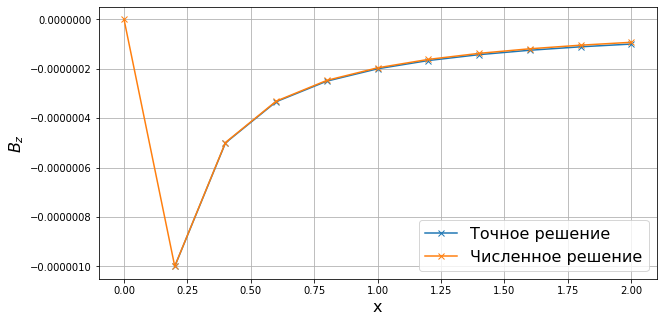

In [8]:
plt.figure(figsize=(10,5))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel(r'$B_z$', fontsize=16)

# Координаты узлов сетки и значение магнитной индукции вдоль направления (x,y=0,z=0)
X  = grid_XYZ[0, grid_Nx//2:, grid_Nz//2, 0]
Bz = B[0, grid_Nx//2:, grid_Nz//2, 2]

plt.plot(X, Bz_theor(wire_I, X), label = 'Точное решение', marker='x' )
plt.plot(X, Bz, label = 'Численное решение', marker='x' )
plt.legend(loc='best', fontsize=16);

Можно вычислить относительную ошибку решения $\varepsilon$ – просто возьмем абсолютную величину разницы численного и точного решений и отнормируем на само решение.

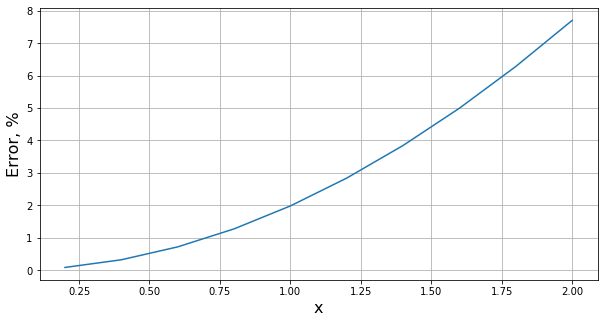

In [9]:
plt.figure(figsize=(10,5))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('Error, %', fontsize=16)
plt.plot(X, abs( (Bz_theor(wire_I, X) - Bz)/Bz ) * 100);

## Задание

Как можно видеть, ошибка растёт при удалении от провода с током. Объясните почему. Измените длину провода, число элементарных участков, при помощи которых мы моделируем провод и число точек расчётной сетки. Посмотрите, как будет меняться ошибка вычислений.